# lets learn espanol

## Step 1: Scrape vocabularies from pdf (aka copy paste them into text file and read that)

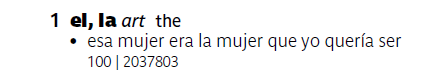

This is what our vocabularies look like in the pdf (starting at page 23)

And this is what I want them to be like after scraping:

In [216]:
import pandas as pd
d = {"spanish": "el, la", "english": "the", "word_class": "art", "example_sentence": "esa mujer era la mujer que yo queria ser"}
example_df = pd.DataFrame(d, index=[0])
example_df.head()

,spanish,english,word_class,example_sentence
0,"el, la",the,art,esa mujer era la mujer que yo queria ser


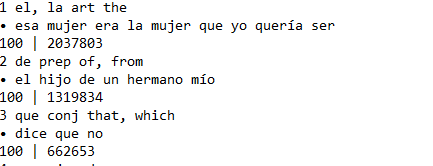

In [264]:
df = pd.DataFrame(columns = ['index', 'spanish', 'english', 'word_class', 'example_sentence'])
i = 1
check = 0
with open('words.txt','r', encoding='utf8') as file: # have to specify encoding
    while i <= 1000:       
        
        # Read in first line and append to dict
        d = read_line1(file, i)
        
        # If read_line1 was not successfull we go to next line and try again
        if d is None:
            continue
        else:
            # Read second line aka example sentence
            d = read_line2(file,d)
        
            # Skip third line
            d = read_line3(file,d)
            
            # Clear paragraphs from example sentence
            d['example_sentence'] = d['example_sentence'].replace("\n"," ")
            
            if check:
                print("VOCAB%03d: %s\n" % (i, d))
            
            # Append to df            
            df = df.append(d, ignore_index=True)
                           
            # Increment counter
            i += 1

In [266]:
# Save df
df.to_pickle('spanish_first1000.pkl')

## ⬆️ Step 1 check!!! 

## Step 2: write df to anki deck

In [2]:
#!/usr/bin/env python3
import pandas as pd
import random
import genanki

# Filename of the data file
data_filename = "spanish_first1000.pkl"

# Filename of the Anki deck to generate
deck_filename = "spanish1000.apkg"

# Title of the deck as shown in Anki
anki_deck_title = "spanish1000"

# Name of the card model
anki_model_name = "spanish"

# Create the deck model
model_id = random.randrange(1 << 30, 1 << 31)

style = """
.card {
 font-family: arial;
 font-size: 24px;
 text-align: center;
 color: black;
 background-color: white;
}
.hanzi {
 font-size: 64px;
}
"""

anki_model = genanki.Model(
    model_id,
    anki_model_name,
    fields=[{"name": "spanish"}, {"name": "english"},{"name": "word_class"}, {"name": "example_sentence"}],
    templates=[
        {
            "name": "Card 1", # spanish in front, Rest back
            "qfmt": '<p class="spanish">{{spanish}}</p>', # front side
            "afmt": '{{FrontSide}}<hr id="answer"><p class="english">{{english}}</p><p class="word_class">{{word_class}}</p><p class="example_sentence">{{example_sentence}}</p>' # back side
        },
        {
            "name": "Card 2", # english front, rest back
            "qfmt": '<p class="english">{{english}}</p>', # front side
            "afmt": '{{FrontSide}}<hr id="answer"><p class="spanish">{{spanish}}</p><p class="word_class">{{word_class}}</p><p class="example_sentence">{{example_sentence}}</p>', # back side
        },
    ],
    css=style,
)

# Retrieve vocabulary
df = pd.read_pickle(data_filename)
anki_notes = []

# Loop through
for index, row in df.iterrows():
    anki_note = genanki.Note(
    model=anki_model,
    # spanish english word_class example sentence
    fields=[row['spanish'], row['english'], row['word_class'], row['example_sentence']],
    )
    anki_notes.append(anki_note)

# Shuffle flashcards
random.shuffle(anki_notes)

anki_deck = genanki.Deck(model_id, anki_deck_title)
anki_package = genanki.Package(anki_deck)

# Add flashcards to the deck
for anki_note in anki_notes:
    anki_deck.add_note(anki_note)

# Save the deck to a file
anki_package.write_to_file(deck_filename)

print("Created deck with {} flashcards".format(len(anki_deck.notes)))

Created deck with 1000 flashcards


# Subfunctions

In [206]:
def skip_line(file):
    """
    reads in line of file but does not return it and thereby (hopefully) effectively skips it
    """
    file.readline()     

In [207]:
def readnsplit(file):
    """
    Read line, split it, return it
    """
    return file.readline().split()

In [263]:
def read_line1(file, i, d=init_vocabulary()):
    """
    Write line into dictionary if beginning of string is a number (check0) and if that number matches i (check1)
    """        
    line = readnsplit(file)
    
    # Debug
    di = 0 
    if i == di:
        print("\nDEBUG LINE: %s\n" % line)    
    
    # check0
    if not line[0][0].isnumeric(): # necessary to use two different if statements as letter at start of line will cast error at check1
        return None    
    
    # check1
    if not int(line[0]) == i:        
        return None
    
    # write to dict
    else:
        d['index'] = line[0]             
    
    # Join elements that are seperated by comma
    j = 1    
    while j < len(line):        
        word = line[j]        
        if word[-1] == ',': # this should take care of spanish multiple spanish values like "el, la" and some english stuff like "very, really"
            line[j:(j+2)] = [" ".join(line[j:j+2])] # join me and the next one
        j += 1       
    
    line[3:] = [" ". join(line[3:])] # this takes care of the rest of the english values
    
    # Append to dictionary       
    d['spanish'] = line[1]
    d['english'] = line[3]
    d['word_class'] = line[2] 
    return d        

In [235]:
def read_line2(file, d):
    """
    Read example sentence. In case line 1 is not finished yet clear that up first.
    """
    line = file.readline()
    if line[0] == '•':
        d['example_sentence'] = line[2:]
    else:
        d['english'] = d['english'] + line
        d = read_line2(file,d)
    return d

In [236]:
def read_line3(file,d):
    """
    Moves filepointer to next line. Read in remains of example senetence if necessary and then skip line.
    """
    line = file.readline()
    if len(line.split()) < 2 or not line.split()[1] == "|":
        d['example_sentence'] = d['example_sentence'] + line
        skip_line(file)
    return d

In [237]:
def init_vocabulary():
    return {"index": 0, "spanish": "", "english": "", "word_class": "", "example_sentence": ""}